In [1]:
import jax
import torch
import jax.numpy              as jnp
import numpy                  as np
import matplotlib.pyplot      as plt
import seaborn                as sns
import xarray                 as xr
import h5py

import jax_cfd.base           as cfd
import jax_cfd.base.grids     as grids
import jax_cfd.spectral       as spectral

import dataclasses

In [2]:
# Set simulation parameters
viscosity     = 1e-3
max_velocity  = 7.
cfl           = 0.5
final_time    = 30.
x_min         = 0.
x_max         = 2. * jnp.pi
nx            = 256
y_min         = x_min
y_max         = x_max
ny            = nx
dx            = (x_max - x_min) / nx
init_kmaxdx   = jnp.pi / 30
init_kmax     = init_kmaxdx / dx
seed          = 42                            # seed for random number generation
smooth        = True                          # use anti-aliasing
nb_snapshots  = 512                           # nb of snapshots in generated dataset
first_ignored = int(nb_snapshots // 10)       # nb of ignored snapshots from the simulation start
outer_steps   = first_ignored + nb_snapshots  # nb of snapshots in VRAM at   the simulation end

# Define grid
grid = grids.Grid(
  (nx, ny),
  domain=((x_min, x_max), (y_min, y_max))
)

# Set time step
dt = cfd.equations.stable_time_step(max_velocity, cfl, viscosity, grid)

# Set time integration
step_fn = spectral.time_stepping.crank_nicolson_rk4(
  spectral.equations.ForcedNavierStokes2D(viscosity, grid, smooth=smooth), dt
)

# Set number of time steps
# between two consecutive snapshots
# in the dataset that will be generated
inner_steps = int((final_time // dt) // outer_steps)

print(f"inner_steps: {inner_steps}")

# Set trajectory function
# to save snapshots
trajectory_fn = cfd.funcutils.trajectory(
  cfd.funcutils.repeated(step_fn, inner_steps), outer_steps
)

# Set initial condition
v0 = cfd.initial_conditions.filtered_velocity_field(
  jax.random.PRNGKey(seed), grid, max_velocity, init_kmax
)
vorticity0     = cfd.finite_differences.curl_2d(v0).data
vorticity_hat0 = jnp.fft.rfftn(vorticity0)

# Compute time series in spectral space
_, trajectory = trajectory_fn(vorticity_hat0)

# Convert time series to vorticity space
vorticity_space = jnp.fft.irfftn(trajectory, axes=(1, 2))

print("Completed simulation!")

inner_steps: 30
Completed simulation!


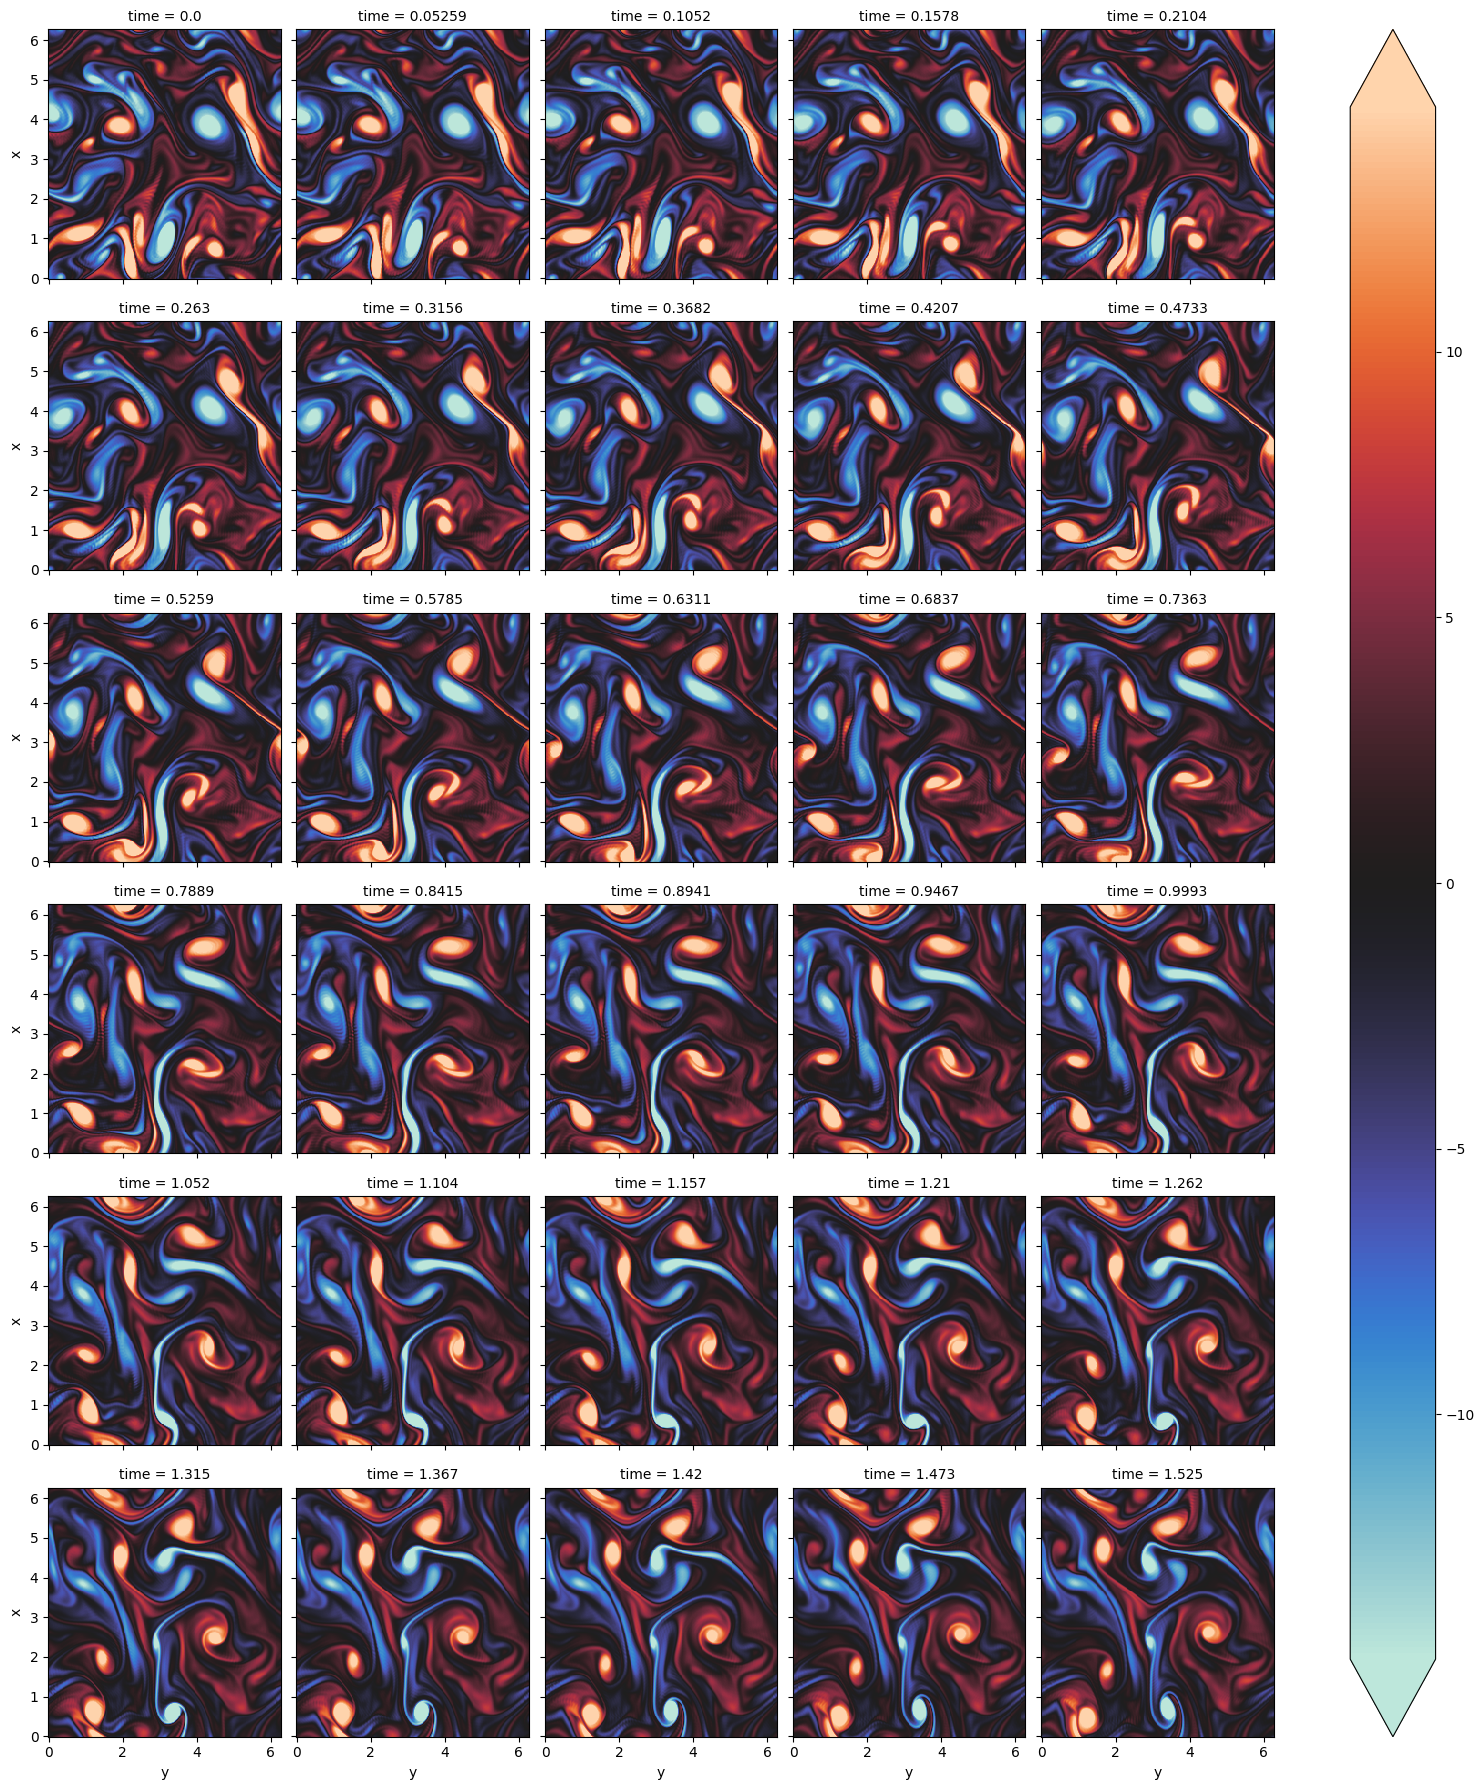

In [3]:
# Plot simulation results
coords   = jnp.arange(nx) * dx
nsnaps   = min(nb_snapshots, 30)
coordsxr = {
  'time': dt * jnp.arange(nsnaps) * inner_steps,
  'x': coords,
  'y': coords,
}
snaps = xr.DataArray(
  vorticity_space[first_ignored:first_ignored+nsnaps], 
  dims=["time", "x", "y"], coords=coordsxr
).plot.imshow(
  col='time', col_wrap=5, cmap=sns.cm.icefire, robust=True
)
snaps.fig.savefig("data.png", dpi=300, bbox_inches="tight")

In [4]:
# Save simulation data to HDF5 file
# shape: (nb_snapshots, nx, ny)
vs = np.array(vorticity_space[first_ignored:])
print(vs.shape, vs.dtype, type(vs))
assert vs.shape[0] == nb_snapshots

with h5py.File("data.h5", "w") as f:
    f.create_dataset("data", data=vs)

(512, 256, 256) float32 <class 'numpy.ndarray'>


In [41]:
# Save shifted min-max normalized simulation data and downsampled counterpart (1/4 as scale factor) to HDF5 file
# Downsampled data is input (conditioning) to Latent Diffusion Model
from torch.nn.functional import interpolate

scale_factor  = 0.25
hr_tensor     = torch.from_numpy(vs)
lr_tensor     = interpolate(hr_tensor.unsqueeze(1), scale_factor=scale_factor, mode='bicubic', antialias=True).squeeze()
hr_mean       = torch.mean(hr_tensor).item()
hr_std        = torch.std(hr_tensor).item()
hr_max        = hr_tensor.max().item()
hr_min        = hr_tensor.min().item()
dhr_max_min   = hr_max - hr_min
hr_normalized = 2.0 * (hr_tensor - hr_min) / dhr_max_min - 1.0
lr_normalized = 2.0 * (lr_tensor - hr_min) / dhr_max_min - 1.0
print(f"hr_mean: {hr_mean}")
print(f"hr_std:  {hr_std}")
print(f"hr_max:  {hr_max}")
print(f"hr_min:  {hr_min}")
print()
print(f"hr_normalized.max(): {hr_normalized.max().item()}")
print(f"hr_normalized.min(): {hr_normalized.min().item()}")
print(f"lr_normalized.max(): {lr_normalized.max().item()}")
print(f"lr_normalized.min(): {lr_normalized.min().item()}")
hrn = hr_normalized.numpy()
lrn = lr_normalized.numpy()
with h5py.File("data_normalized.h5", "w") as f:
    f.create_dataset("hr", data=hrn)
    f.create_dataset("lr", data=lrn)

hr_mean: 1.072039594873786e-07
hr_std:  4.724335670471191
hr_max:  27.49285888671875
hr_min:  -35.87305450439453

hr_normalized.max(): 1.0
hr_normalized.min(): -1.0
lr_normalized.max(): 0.9759161472320557
lr_normalized.min(): -0.9422967433929443


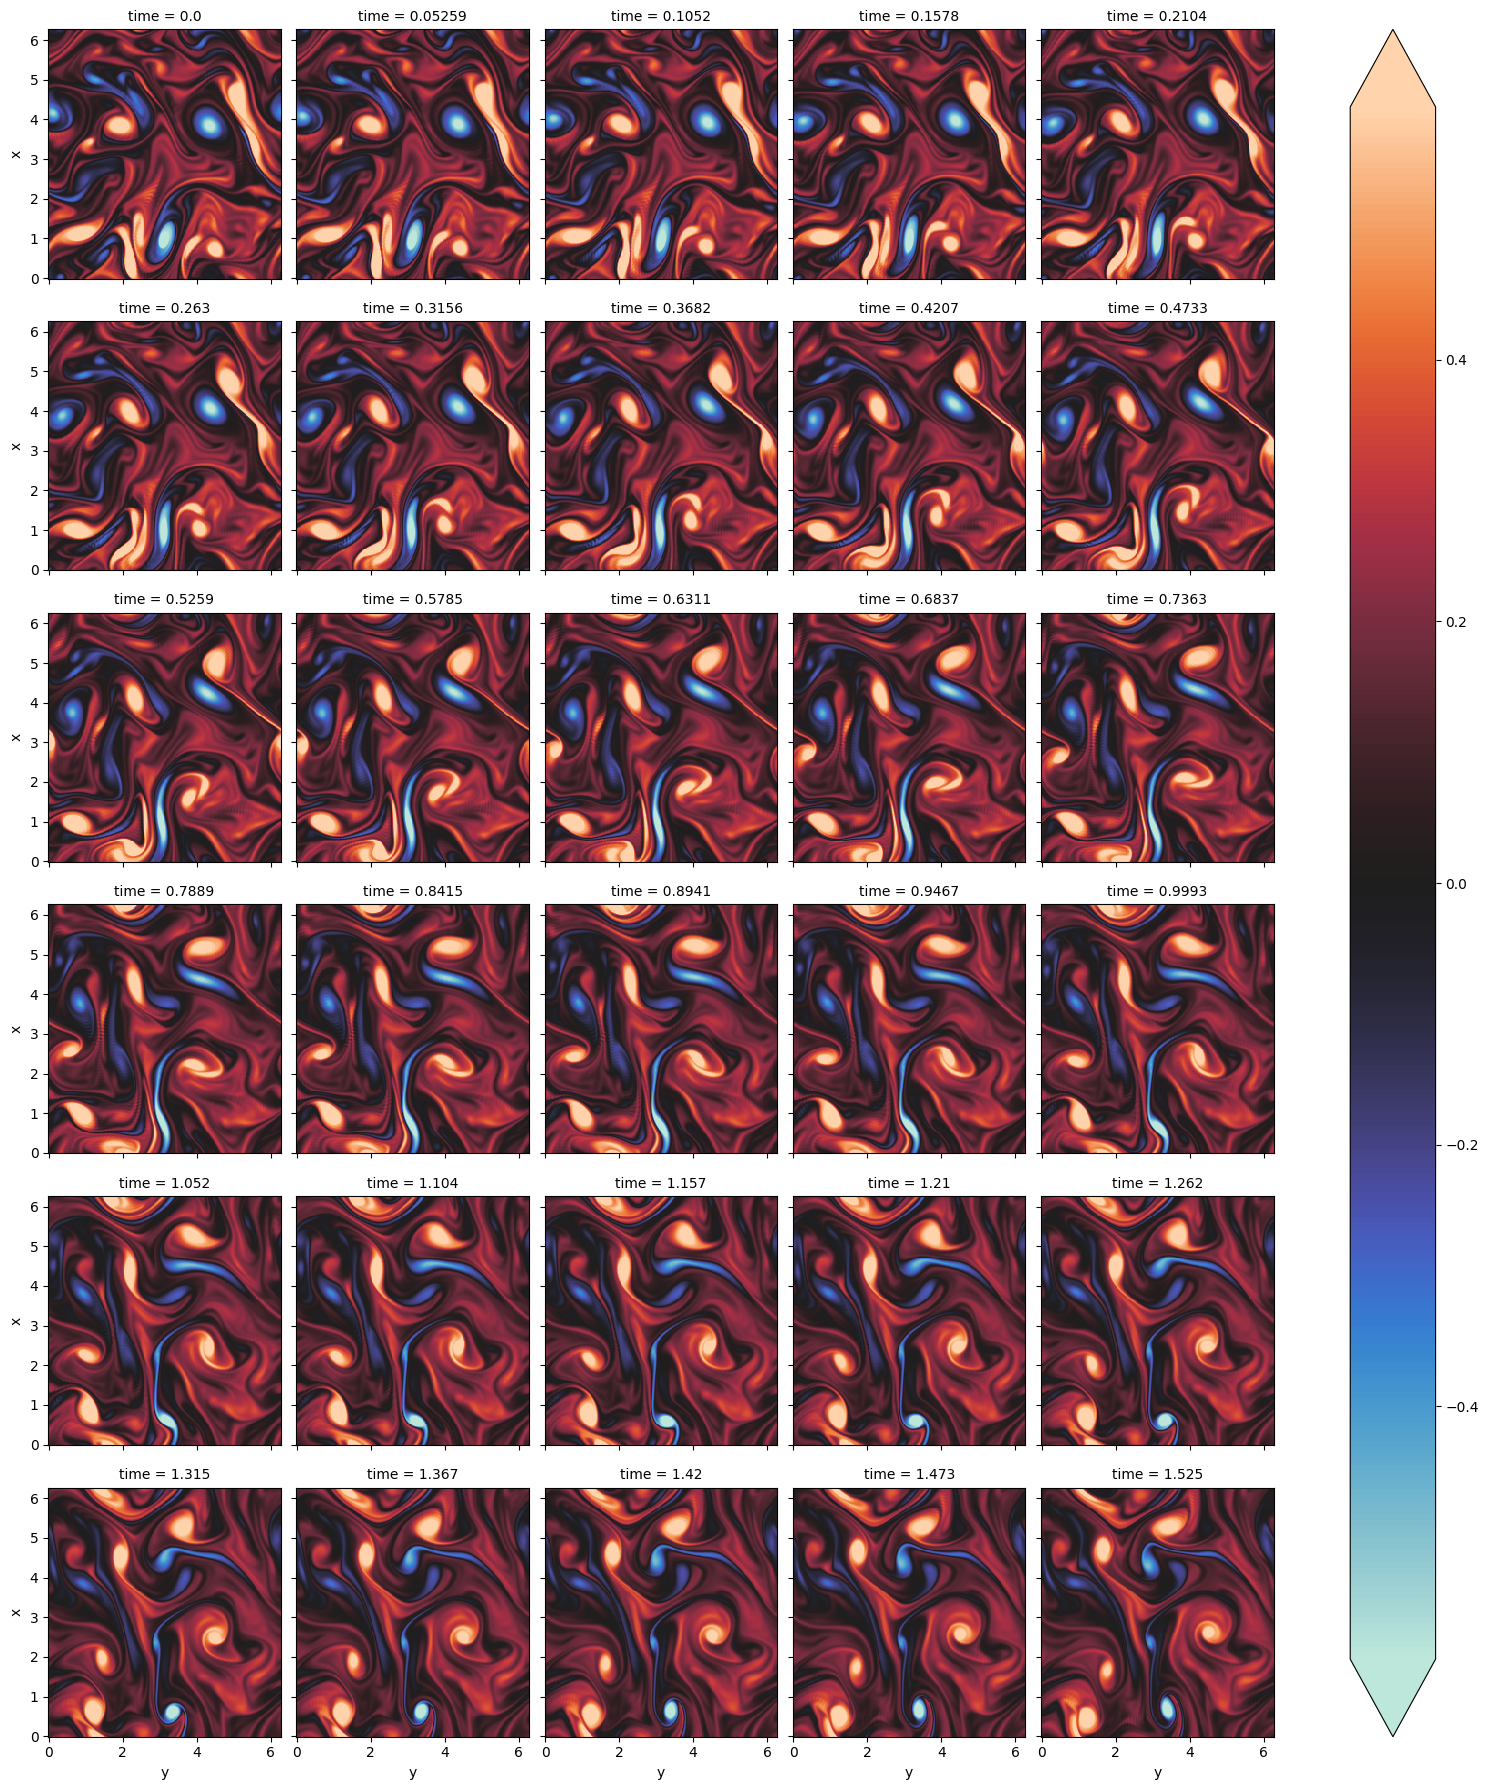

In [43]:
# Plot normalized simulation results
coords   = jnp.arange(nx) * dx
coordsxr = {
  'time': dt * jnp.arange(nsnaps) * inner_steps,
  'x': coords,
  'y': coords,
}
snaps = xr.DataArray(
  hrn[:nsnaps], 
  dims=["time", "x", "y"], coords=coordsxr
).plot.imshow(
  col='time', col_wrap=5, cmap=sns.cm.icefire, robust=True
)
snaps.fig.savefig("data_normalized.png", dpi=300, bbox_inches="tight")

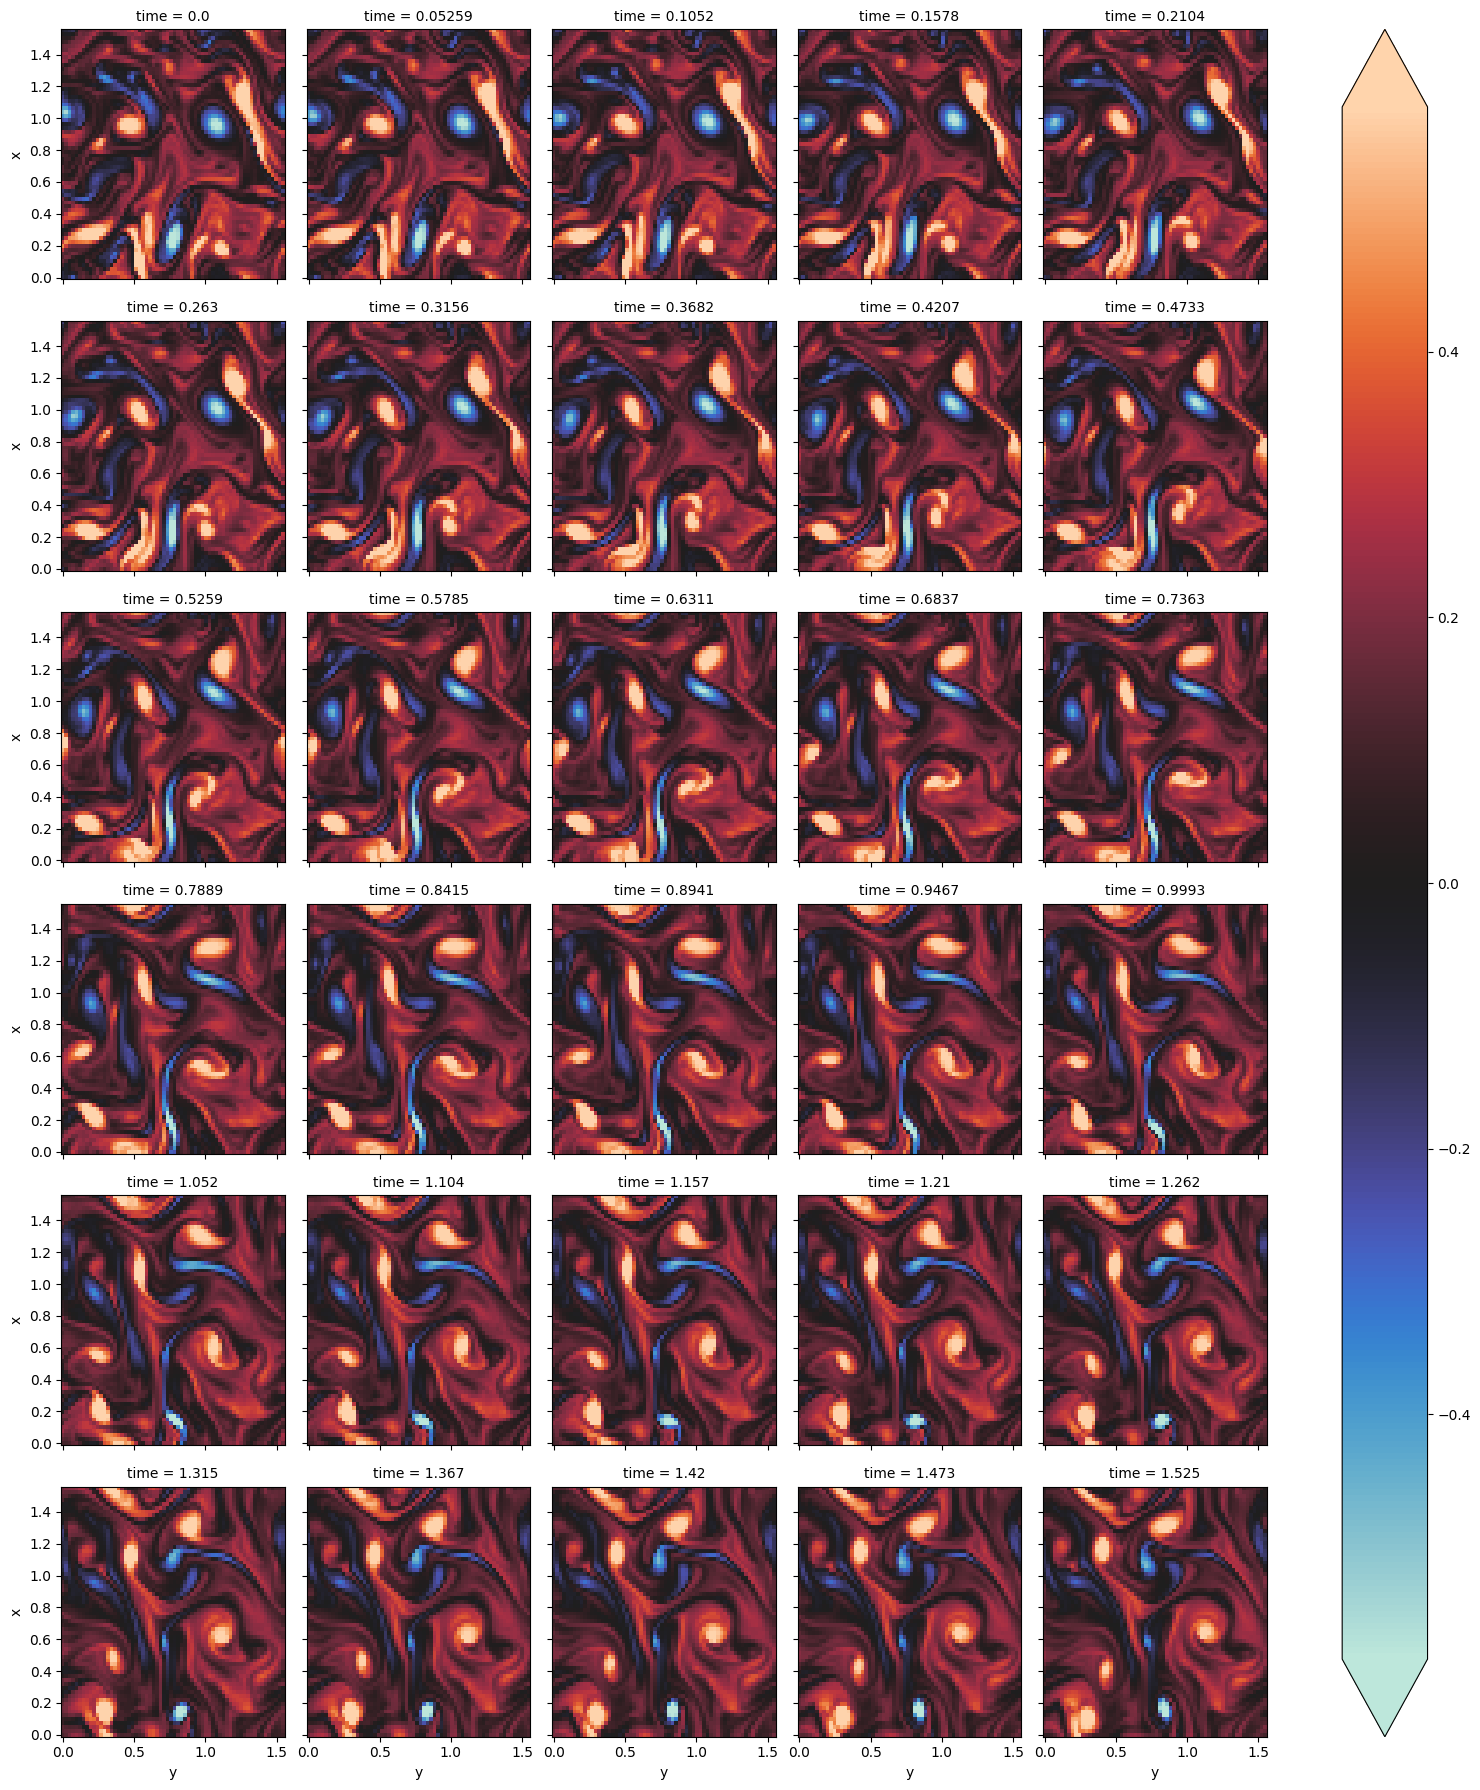

In [44]:
# Plot downsampled normalized simulation results
coords   = jnp.arange(int(nx * scale_factor)) * dx
coordsxr = {
  'time': dt * jnp.arange(nsnaps) * inner_steps,
  'x': coords,
  'y': coords,
}
snaps = xr.DataArray(
  lrn[:nsnaps], 
  dims=["time", "x", "y"], coords=coordsxr
).plot.imshow(
  col='time', col_wrap=5, cmap=sns.cm.icefire, robust=True
)
snaps.fig.savefig("data_normalized_lr.png", dpi=300, bbox_inches="tight")